# Week3 Assignments
You will get some hands-on experience with Optuna through this week's assignments. Similar to the tutorial of the first week, the [red wine dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) will be used in this week's assignments. 

**Guidelines of submitting assignments**:
- For each assignment, a code skeleton is provided. Please put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments. 
- Some assignments also require you to answer questions (in text) or capture screenshots in order to earn points. For each question, please put your text answers **in the same Markdown cell as the question** and your screenshots into a single PDF file. For each screenshot, please clearly indicate which assignment it corresponds to in your PDF file. 
- When preparing your submission, be sure to include your assignment notebook with code cell outputs. It's important that these outputs are current and reflect the latest state of your code, as your grades may depend on them. Additionally, please include the PDF file that contains your screenshots in your submission. 

In [2]:
# import packages
import os
import pandas as pd
import numpy as np

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.samplers import TPESampler

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb

In [3]:
# Random seed for making the assignments reproducible
RANDOM_SEED = 42

# MLflow service URI
mlflow_tracking_uri = "http://mlflow-server.local"

In [4]:
# prepare training and testing data
data = pd.read_csv("winequality-red.csv", delimiter=";")

X = data.drop("quality", axis=1)
y = data["quality"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [5]:
# An overview of the original dataset
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print(f"The dimension of train_x is {train_x.shape}")
print(f"The dimension of train_y is {train_y.shape}")
print(f"The dimension of test_x is {test_x.shape}")
print(f"The dimension of train_x is {test_y.shape}")

The dimension of train_x is (1199, 11)
The dimension of train_y is (1199,)
The dimension of test_x is (400, 11)
The dimension of train_x is (400,)


## Assignment 1: The basic use of Optuna (2 points)
Train a [LightGBM regression model](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) to predict red wine quality and use Optuna to find the optimal hyperparameter combination for the model. **Please use the sklearn API as you did in the first week's assignments.**

This assignment has the following requirements:

1) Create an Optuna study named ***lgbm-wine-1***. The target of the optimization is to minimize the MAE (mean absolute error) of the model when evaluating the model against the testing dataset. The hyperparameters to be tuned and their search ranges are shown below. Some of the hyperparameter values are fixed. The hyperparameter values should be sampled in a linear domain if not separately specified. 

| Hyperparameter    | Explanation                                                                 | type    | range                                                                    |
|:-------------------|:-----------------------------------------------------------------------------|:---------|:--------------------------------------------------------------------------|
| n_estimators      | The number of decision trees.                                               | integer | 1000 (fixed value)                                                       |
| learning_rate     | The step size of the gradient descent. It controls how quickly the model fits and then overfits the training data.              | float   | [0.001, 0.1] (sampled from the logarithmic domain) |
| subsample         | The percentage of training samples to be used to train each tree. `subsample*100%` of the training samples will be randomly selected for training.        | float   | [0.05, 0.5]                                                              |
| subsample_freq    | Subsampling frequency. The subsampling will be performed again after `subsample_freq` trees have been trained.                                                     | integer | 1 (fixed value)                                                          |
| colsample_bytree  | The percentage of features to use when training each tree.                | float   | [0.05, 0.5]                                                              |
| min_child_samples | A leaf node should have `min_child_samples` data points to be further splitted. | integer | [20, 100]                                                                |
| num_leaves        | Max number of nodes in a single tree.                                       | integer | [2, 2^10]                                                                |
| random_state      | The seed for random number generation for reproducibility.                                   | integer | RANDOM_SEED (fixed value, RANDOM_SEED has been defined as a variable in a previous cell)                                                |

2) Use [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) as the sampler for the hyperparameter sampling and use `RANDOM_SEED` as the seed of the sampler. 

3) The Optuna study should perform 100 trials.

4) The study history should be persisted in a relational database (`optuna.sqlite3`) so that the study can be loaded and analyzed later. 

Hints:
- [How to sample hyperparameter values in the logarithmic domain?](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float)
- [How to configure a study to use a specific sampler and persist study history in a specific database?](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html#optuna-create-study)
- It may take some time run 100 trials, so you could test your code using a smaller number of trials and increase the number to 100 after you're sure your code works. Remember to delete the study before rerunning the study to avoid the error of duplicated study. The code for deleting an existing study from a database can be found after the assignment code cell of this assignment. 


*More reading material: If you are interested, [the LightGBM documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters) explains the use of each hyperparameter in more details.*

In [12]:
# Define the objective function
def objective(trial):
    ### START CODE HERE
    params = {
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 0.5),
        "subsample_freq": 1,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.5),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 100),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "random_state": RANDOM_SEED
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(train_x, train_y)

    predictions = model.predict(test_x)

    score = mean_absolute_error(test_y, predictions)
    return score
    ### END CODE HERE

# Remember to assign "lgbm-wine-1" as the study_name to your Optuna study. 
study_name = "lgbm-wine-1"

# For this assignment, it is enough to use a simple sqlite3 database for persisting study history
storage = "sqlite:///optuna.sqlite3"

# Create (and run) the study and record the history in the SQlite3 database file
### START CODE HERE
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED),
    storage=storage,
    study_name=study_name,
    load_if_exists=True
)
study.optimize(objective, n_trials=100)
### END CODE HERE

print("Best MAE", study.best_value)
print("Best params:", study.best_trial.params)

[I 2023-11-22 14:47:33,190] A new study created in RDB with name: lgbm-wine-1


[I 2023-11-22 14:47:34,384] Trial 0 finished with value: 0.48305757514051956 and parameters: {'learning_rate': 0.005611516415334507, 'subsample': 0.4778214378844623, 'colsample_bytree': 0.3793972738151323, 'min_child_samples': 68, 'num_leaves': 161}. Best is trial 0 with value: 0.48305757514051956.
[I 2023-11-22 14:47:37,496] Trial 1 finished with value: 0.6685091743119267 and parameters: {'learning_rate': 0.002051110418843397, 'subsample': 0.07613762547568977, 'colsample_bytree': 0.4397792655987208, 'min_child_samples': 68, 'num_leaves': 726}. Best is trial 0 with value: 0.48305757514051956.
[I 2023-11-22 14:47:38,359] Trial 2 finished with value: 0.5330860406894041 and parameters: {'learning_rate': 0.0010994335574766201, 'subsample': 0.48645943347289744, 'colsample_bytree': 0.4245991883601898, 'min_child_samples': 37, 'num_leaves': 188}. Best is trial 0 with value: 0.48305757514051956.
[I 2023-11-22 14:47:38,923] Trial 3 finished with value: 0.5338040960963436 and parameters: {'learn

Best MAE 0.42049257783045446
Best params: {'learning_rate': 0.044003653606792495, 'subsample': 0.46109394814578664, 'colsample_bytree': 0.49833000276908107, 'min_child_samples': 20, 'num_leaves': 183}


Expected output:

Best MAE 0.42049257783045446

Best params: {'colsample_bytree': 0.49833000276908107, 'learning_rate': 0.044003653606792495, 'min_child_samples': 20, 'num_leaves': 183, 'subsample': 0.46109394814578664}




In [11]:
# Uncomment the code below and run this cell if you want to delete the study created in assignment 1 in the database

optuna.delete_study(study_name="lgbm-wine-1", storage="sqlite:///optuna.sqlite3")

## Assignment 2: Analyzing an Optuna study (2 points)
Optuna offers utility functions for visualizing the optimization process (i.e., study history). For example, it can plot the hyperparameter importance and the relationship between a hyperparameter and the objective. In this assignment, you need to analyze the study created in Assignment 1, adjust the search ranges of some hyperparameters to obtain better MAE.

This assignment is divided into three parts and you need to answer a question after completing the coding in each part. For each question, **please put your answer to the same Markdown cell as the question.** Detailed instructions of each part can be found below. (There is not a single correct answer to these questions, so any reasonable answer will be considered for points.)

In [8]:
import plotly.io as pio

# Configure Jupyter Notebook to render plotly figures drawn by Optuna
pio.renderers.default = "notebook"

### 2a) Hyperparameter importance
Load the "lgbm-wine-1" study created in Assignment 1 and plot the importance of the hyperparameters in the study. Similar to the tutorial, use the [FanovaImportanceEvaluator](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html#optuna.importance.FanovaImportanceEvaluator) as the importance evaluator and set `RANDOM_STATE` as the seed for the evaluator for reproducibility. 

In [13]:
# Plot the hyperparameter importance
study_name = "lgbm-wine-1"
storage = "sqlite:///optuna.sqlite3"

### START CODE HERE
study = optuna.load_study(study_name=study_name, storage=storage)
fig = optuna.visualization.plot_param_importances(study, evaluator=optuna.importance.FanovaImportanceEvaluator(seed=RANDOM_SEED))
fig.show()
### END CODE HERE

### Question for Assignment 2a
What are the most two important hyperparameters in the "lgbm-wine-1" study created in Assignment 1?

Answer: "min_child_samples" and "subsample"

### 2b) The impact of hyperparameters
Plot the relationships of the most two important hyperparameters and the objective in a slice plot. 

Hint: [How to plot the relationship between a hyperparameter and the objective?](https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_slice.html)

In [14]:
# Plot the relationships between the most two important hyperparameters and the objective

### START CODE HERE
fig = optuna.visualization.plot_slice(study, params=["subsample", "min_child_samples"])
fig.show()
### END CODE HERE

### Question for Assignment 2b
Now you know the most two important hyperparameters that affect the objective value. Looking at the positions of the points in the slice plot, which area the points that resulted in better MAE are concentrated on? How would you adjust the search ranges of these two hyperparameters in the next study?

Answer: For min_child_samples value, the perfect area is from 20 to 40. For subsample value, the perfect area is from 0.4 to 0.5. I will adjust the search ranges of these two hyperparamenters into the perfect value ranges we got from this slice plot.

### 2c) An improved Optuna study
Create a new study named ***lgbm-wine-2*** and use your observation in Assignment 2b to adjust the search ranges of the most two important hyperparameters to improve MAE (keep values/search ranges of other hyperparameters as the same as in Assignment 1).

In this assignment, you need to:
1. run 20 trials in this study, starting with the best hyperparameter combination of the previous study.
1. use TPESampler (with `RANDOM_SEED` as the seed) for hyperparameter sampling,
1. track the trials in an MLflow experiment,
1. persist the study history in the "optuna.sqlite3" database file,

**Hints**: 
- [How to log Optuna trials to MLflow?](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.MLflowCallback.html)
- To start the new study using the best hyperparameter combination of the previous study, you can 1) load the previous study named "lgbm-wine-1", 2) retrieve the optimal hyperparameters combination of the "lgbm-wine-1" study, 3) create a new study, and 4) start the new study from the optimal hyperparameters combination of the previous study. 

You may also find the following links helpful:
- [optuna.load_study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.load_study.html)
- [study.best_params](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.best_params)
- [enqueue_trial](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.enqueue_trial). 

**Note**:
- You will find two approaches for logging trials to an MLflow service: 1) using a callback or 2) using a decorator. The code skeleton has been designed for the first approach but feel free to modify the code if you prefer the second one.  
- If you want to redo this assignment, please remember to first delete the study from the database as well as the trials logged to MLflow. If you want to delete all the trials in MLflow, don't delete the experiment, as deleting the experiment using the UI will not really delete the experiment in the PostgreSQL database used by MLflow, which will cause problems when recording trials under an experiment with the same name as the deleted experiment. Instead, you can keep the experiment and delete the trials, as shown in the image below. (If you feel like permanently deleting MLflow experiments from the PostgreSQL database, please check [here](https://version.helsinki.fi/luoyumo/engineering_of_ml_systems/-/blob/master/mlflow.md?ref_type=heads)).

![](./images/mlflow-delete-trials.jpg)

<details>
    <summary>If callback and decorator are new to you...</summary>
    <p>Briefly speaking, both callbacks and decorators are used to modify or enhance the behavior of another function without modifying its original source code. A callback is a function that is typically provided as an argument to another function. A decorator typically takes another function as an argument. Feel free to google more about them. </p>
</details>


In [19]:
# Define the objective function
def objective(trial):
    ### START CODE HERE
    params = {
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "subsample": trial.suggest_float("subsample", 0.4, 0.5),
        "subsample_freq": 1,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.5),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 40),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "random_state": RANDOM_SEED
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(train_x, train_y)

    predictions = model.predict(test_x)

    score = mean_absolute_error(test_y, predictions)
    return score
    ### END CODE HERE

storage = "sqlite:///optuna.sqlite3"

# name of the previous study in Assignment 1
prev_study_name = "lgbm-wine-1"

# name of the new study
new_study_name = "lgbm-wine-2"

# Load the "lgbm-wine-1" study created in Assignment 1, create a new study that performs 20 trials, starting with the optimal hyperparameter combination 
# of the "lgbm-wine-1" study. You also need to log the trials to MLflow while running the new study
### START CODE HERE
# Load the previous study
prev_study = optuna.load_study(
    storage=storage,
    study_name=prev_study_name,
)

# define the callback function that logs trials to MLflow
mlflc = MLflowCallback(
    tracking_uri=mlflow_tracking_uri,
    metric_name="my metric score"
)

# Create a new study
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED),
    study_name=new_study_name,
    storage=storage,
)

# Run 20 trials, starting with the best combination of the previous study
study.enqueue_trial(prev_study.best_params)
study.optimize(objective, n_trials=20, callbacks=[mlflc])
### END CODE HERE

print("Best MAE", study.best_value)
print("Best params:", study.best_trial.params)

/tmp/ipykernel_6735/3873564527.py:42: ExperimentalWarning:

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.

[I 2023-11-22 14:56:23,541] A new study created in RDB with name: lgbm-wine-2


[I 2023-11-22 14:56:28,070] Trial 0 finished with value: 0.42049257783045446 and parameters: {'learning_rate': 0.044003653606792495, 'subsample': 0.46109394814578664, 'colsample_bytree': 0.49833000276908107, 'min_child_samples': 20, 'num_leaves': 183}. Best is trial 0 with value: 0.42049257783045446.
[I 2023-11-22 14:56:29,290] Trial 1 finished with value: 0.4460252932336216 and parameters: {'learning_rate': 0.03807947176588889, 'subsample': 0.4950714306409916, 'colsample_bytree': 0.3793972738151323, 'min_child_samples': 32, 'num_leaves': 161}. Best is trial 0 with value: 0.42049257783045446.
[I 2023-11-22 14:56:30,685] Trial 2 finished with value: 0.4526702800600073 and parameters: {'learning_rate': 0.016443457513284063, 'subsample': 0.40580836121681996, 'colsample_bytree': 0.4397792655987208, 'min_child_samples': 32, 'num_leaves': 726}. Best is trial 0 with value: 0.42049257783045446.
[I 2023-11-22 14:56:32,521] Trial 3 finished with value: 0.4715303724212911 and parameters: {'learni

Best MAE 0.42049257783045446
Best params: {'learning_rate': 0.044003653606792495, 'subsample': 0.46109394814578664, 'colsample_bytree': 0.49833000276908107, 'min_child_samples': 20, 'num_leaves': 183}


In [18]:
# Uncomment the code below and run this cell if you want to delete the study created in assignment 2 in the database

optuna.delete_study(study_name="lgbm-wine-2", storage="sqlite:///optuna.sqlite3")

### Question for Assignment 2c
What are the best MAE and the best hyperparameter combination obtained from the new study (lgbm-wine-2)?

THe best MAE I got is 0.42049257783045446;
The best hyperparameter combination:<br>
    params = {<br>
        "n_estimators": 1000, <br>
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),<br>
        "subsample": trial.suggest_float("subsample", 0.4, 0.5),<br>
        "subsample_freq": 1,<br>
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.5),<br>
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 40),<br>
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),<br>
        "random_state": RANDOM_SEED<br>
    }

### Screenshot for Assignment 2c
Submit a screenshot of the trails of the "lgbm-wine-2" study in MLflow UI. **Please put the screenshot into your PDF file.**

<details>
    <summary>Example:</summary>
    <img src="./images/trials-mlflow.png" width=1000/>
</details>


![Screenshot from 2023-11-22 11-36-53.png](<attachment:Screenshot from 2023-11-22 11-36-53.png>)
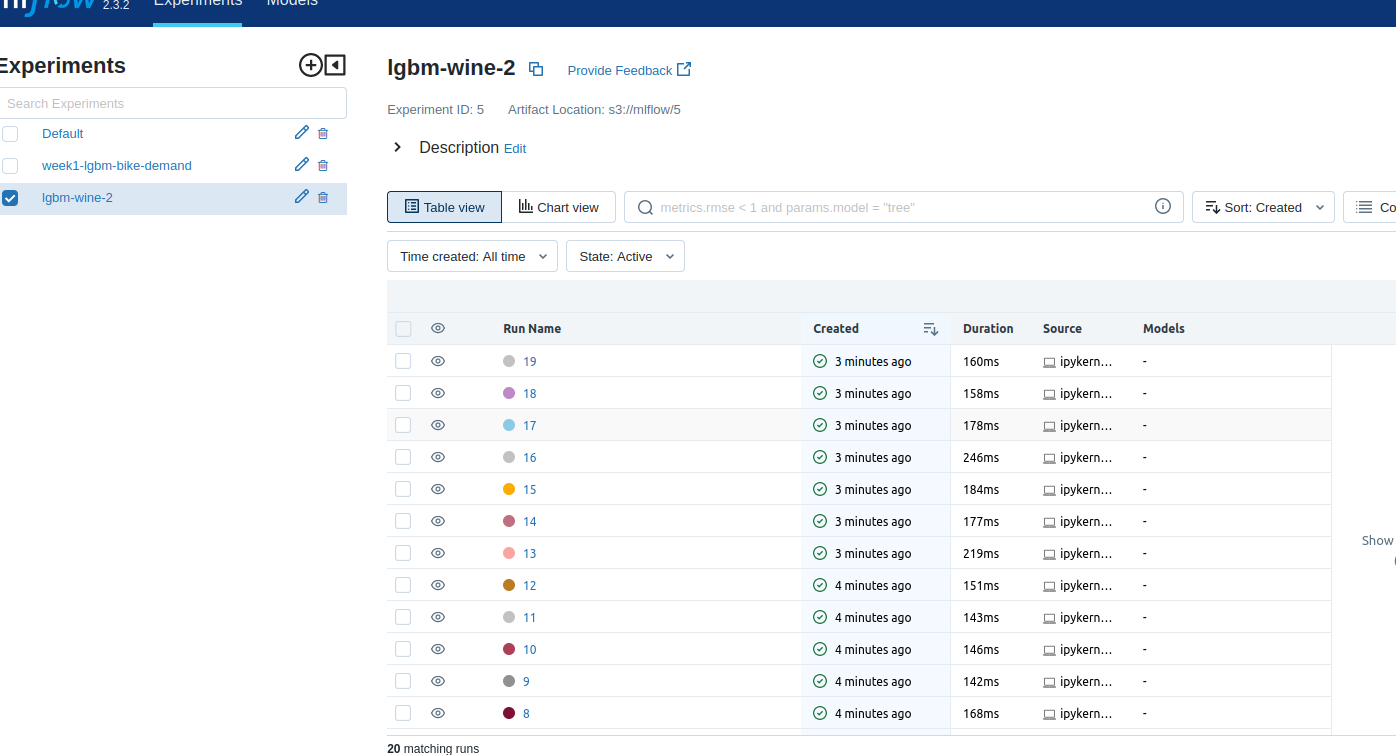

## Assignment 3: More about MLflow (2 points)
### 3a) Find the MLflow run with the best hyperparameter combination
In assignment 2c), you found the best hyperparameter combination for your model. Now, your task is to complete the `find_best_run_id` function. The function receives an MLflow Experiment name as the argument and returns the best MLflow Run ID that resulted in the best hyperparameter combination. In other words, this function should find the MLflow Run with the smallest MAE. 

You may find the following MLflow docs useful:
- [How to retrieve an MLflow experiment given an experiment name?](https://mlflow.org/docs/2.3.2/python_api/mlflow.html?highlight=get_experiment_by_name#mlflow.get_experiment_by_name)
- [How to search runs inside an experiment?](https://mlflow.org/docs/2.3.2/python_api/mlflow.html?highlight=search_runs#mlflow.search_runs)

In [7]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://mlflow-minio.local"
os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"

mlflow.set_tracking_uri(mlflow_tracking_uri)

def find_best_run_id(mlflow_experiment_name: str) -> str:
    """
    Find the ID of the MLflow run with the smallest MAE
    Args:
        mlflow_experiment_name (str): The name of the MLflow experiment where the run should be found
    Return:
        An MLflow run ID
    """
    ### START CODE HERE
    experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    print(runs.loc[runs["metrics.my metric score"].idxmin()])
    best_run = runs.loc[runs["metrics.my metric score"].idxmin()]
    best_run_id = best_run.run_id
    return best_run_id
    ### END CODE HERE

In [9]:
mlflow_experiment_name = "lgbm-wine-2" # same as the Optuna study name 
best_run_id = find_best_run_id(mlflow_experiment_name)
print(best_run_id)

run_id                                                  540aac97e0854c19a67d22dbceebc0fa
experiment_id                                                                          5
status                                                                          FINISHED
artifact_uri                           s3://mlflow/5/540aac97e0854c19a67d22dbceebc0fa...
start_time                                              2023-11-22 12:55:32.859000+00:00
end_time                                                2023-11-22 13:11:45.530000+00:00
metrics.my metric score                                                           0.3375
params.learning_rate                                                0.026952683463793786
params.num_leaves                                                                    325
params.subsample                                                      0.4873061848346192
params.colsample_bytree                                               0.3252127306571775
params.min_child_samp

### 3b) Train a model using the best hyperparameter combination
Your task is to train a model using the best hyperparameter combination found in Assignment 2c). You also need to upload and register the model to MLflow, the model needs to be associated with the MLflow Run where the optimal hyperparameter combination was found.

For example, suppose running the "lgbm-wine-2" study of Assignment 2 created an MLflow Run 14 where the best hyperparameter combination was found, the model created in this assignment needs to be associated with MLflow Run 14, as shown below:

<img src="./images/mlflow-best-run.png" width=1000/>

<img src="./images/mlflow-best-model.png" width=1000/>

Hints:
- You may find the following function helpful: [mlflow.start_run](https://mlflow.org/docs/2.3.2/python_api/mlflow.html#mlflow.start_run) (Pay attention to the use of the `run_id` parameter).
- It would probably be more convenient to retrieve the best hyperparameter combination using `optuna.load_study` rather than from the Mlflow Run. 

In [10]:
study_name = "lgbm-wine-2"
storage = "sqlite:///optuna.sqlite3"

### START CODE HERE
study = optuna.load_study(study_name=study_name, storage=storage)
best_params = study.best_params
model = lgb.LGBMRegressor(**best_params)
model.fit(train_x, train_y)
predictions = model.predict(test_x)
mae = mean_absolute_error(test_y, predictions)

with mlflow.start_run(run_id=best_run_id, nested=True):
    #mlflow.log_params(best_params)
    #mlflow.log_metric("mean_absolute_error", mae)
    mlflow.sklearn.log_model(model, artifact_path="model",registered_model_name="optuna-lgbm-wine")
### END CODE HERE

/home/user/anaconda3/envs/mlops_eng/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'optuna-lgbm-wine' already exists. Creating a new version of this model...
2023/11/24 22:26:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: optuna-lgbm-wine, version 2
Created version '2' of model 'optuna-lgbm-wine'.


### Screenshots for Assignment 3b)
Submit the screenshots of the registered model version info and the corresponding MLflow run. You can take the images in the assignment instructions above as an example. 


![Screenshot from 2023-11-22 11-58-58.png](<attachment:Screenshot from 2023-11-22 11-58-58.png>) ![Screenshot from 2023-11-22 11-59-05.png](<attachment:Screenshot from 2023-11-22 11-59-05.png>) ![Screenshot from 2023-11-22 14-19-04.png](<attachment:Screenshot from 2023-11-22 14-19-04.png>)
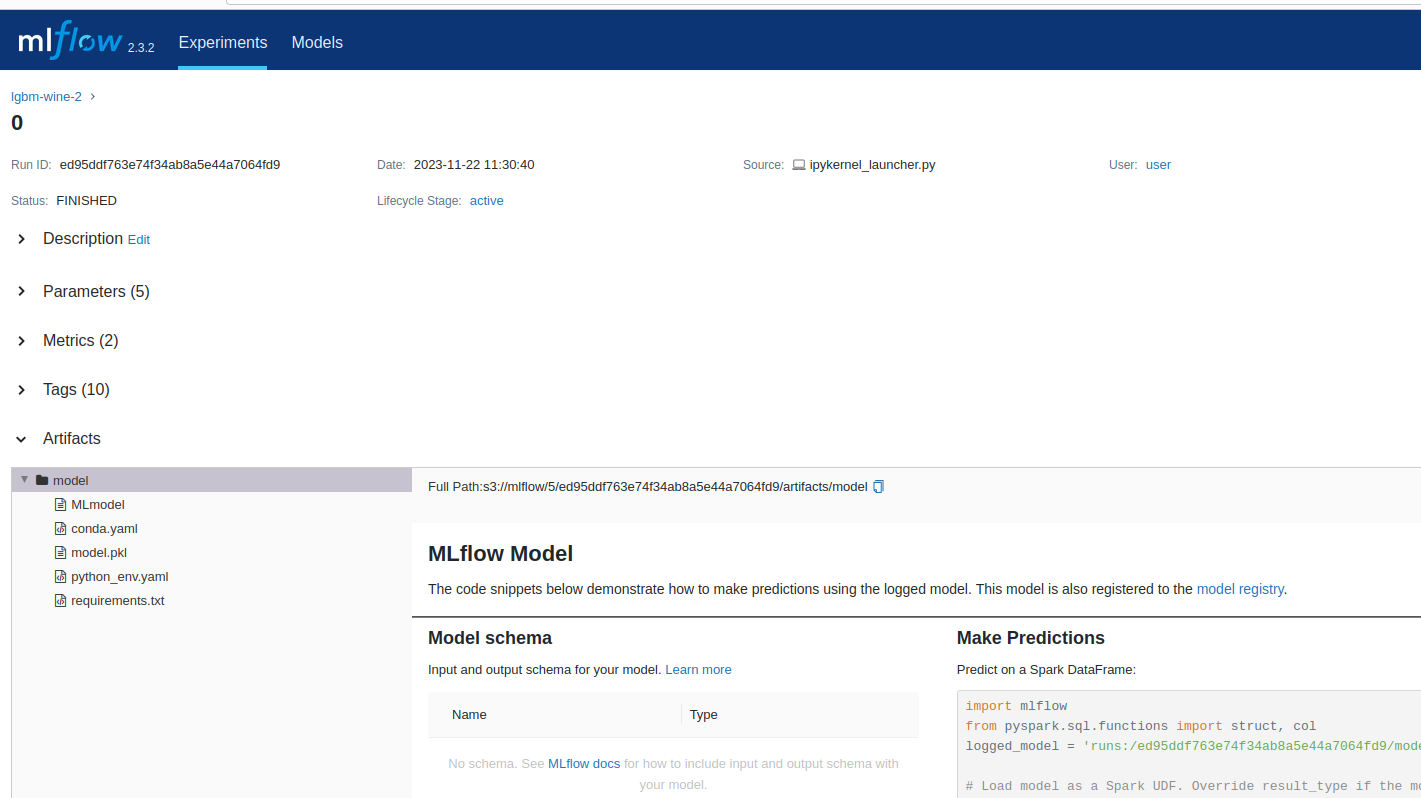
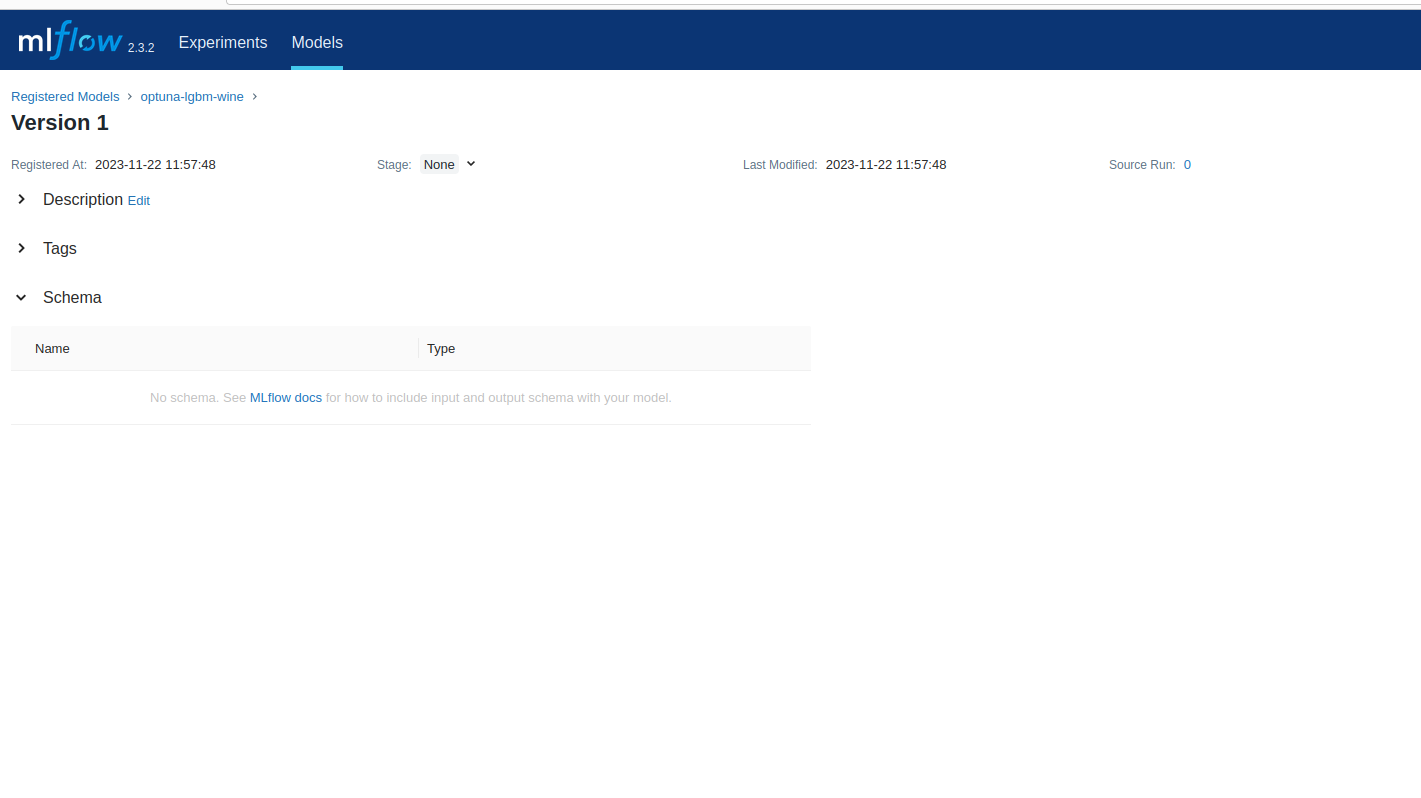
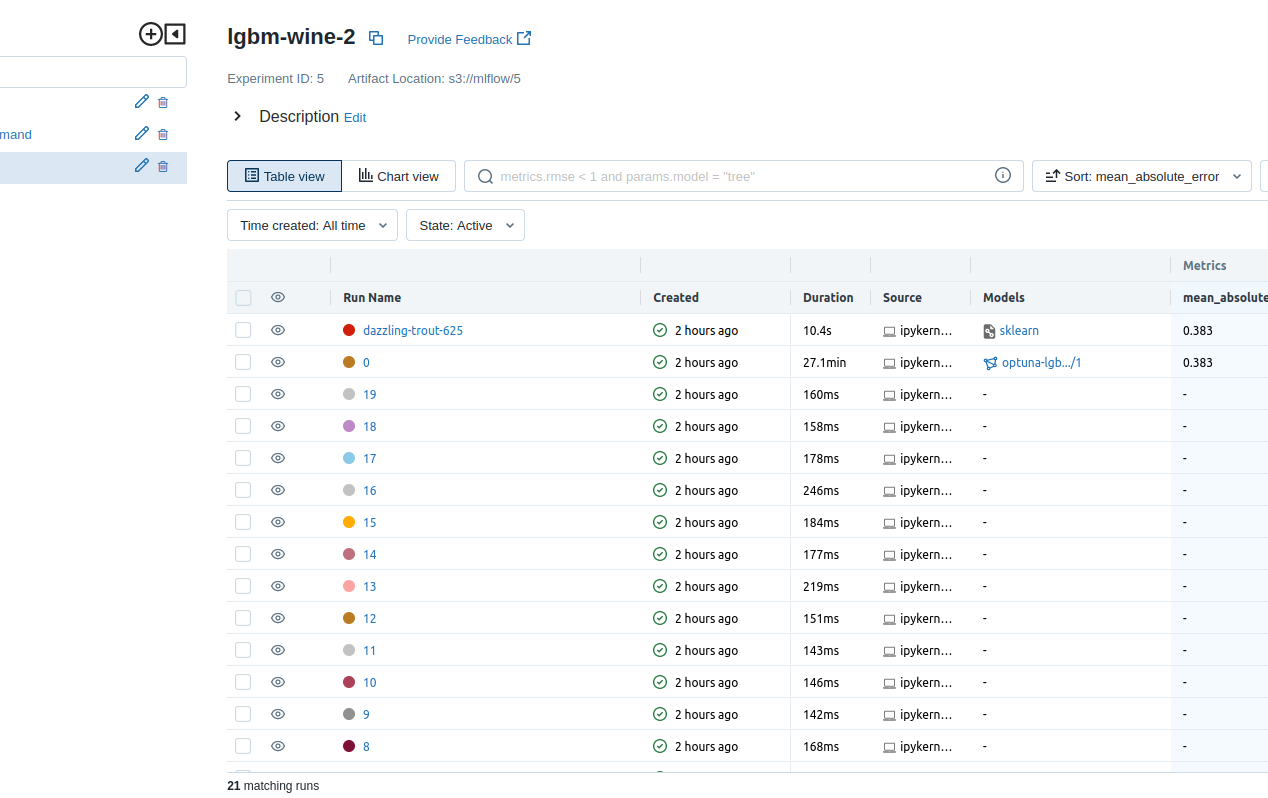

## Assignment 4: Conditional search spaces with Optuna (2 points)
Similar to Example 2 in the Optuna tutorial, your task is to create a new study named "multimodel-wine" that optimizes the hyperparameters of a LightGBM and an [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) regression model for the red wine quality prediction use case and see which library is better in the use case. Similar to the previous assignments, the objective is also a smaller MAE. The hyperparameters to be tuned and their search ranges are given below. Use TPESampler with `RANDOM_SEED` as the random seed. You don't need to track the trials in MLflow or persist them in a relational database. This study should perform 20 trials. 

**LightGBM**: 
| Hyperparameter    | Explanation                                                                 | type    | range                                                                    |
|:-------------------|:-----------------------------------------------------------------------------|:---------|:--------------------------------------------------------------------------|
| n_estimators      | The number of decision trees.                                               | integer | 1000 (fixed value)                                                       |
| learning_rate     | The step size of the gradient descent. It controls how quickly the model fits and then overfits the training data.              | float   | [0.001, 0.1] (sampled from the logarithmic domain) |
| subsample         | The percentage of training samples to be used to train each tree. `subsample*100%` of the training samples will be randomly selected for training.        | float   | [0.05, 1.0]                                                              |
| subsample_freq    | Subsampling frequency. The subsampling will be performed again after `subsample_freq` trees have been trained.                                                     | integer | 1 (fixed value)                                                          |
| colsample_bytree  | The percentage of features to use when training each tree.                | float   | [0.05, 1.0]                                                              |
| min_child_samples | A leaf node should have at least `min_child_samples` data points to be further splitted. | integer | [1, 100]                                                                |
| num_leaves        | Max number of nodes in a single tree.                                       | integer | [2, 2^10]                                                                |
| random_state      | The seed for random number generation for reproducibility.                                   | integer | RANDOM_SEED (fixed value) 

**XGBoost**
| Hyperparameter    | Explanation                                                                 | type    | range                                                                    |
|:-------------------|:-----------------------------------------------------------------------------|:---------|:--------------------------------------------------------------------------|
| n_estimators      | Same as LightGBM.                                               | integer | 1000 (fixed value)                                                       |
| learning_rate     | Same as LightGBM.             | float   | [0.001, 0.1] (sampled from the logarithmic domain) |
| subsample         | Same as LightGBM.            | float   | [0.05, 1.0]                                                              |                                         
| colsample_bytree  | Same as LightGBM.                | float   | [0.05, 1.0]                                                              |
| min_child_weight | Minimum sum of instance weight needed for a leaf mode to be further splitted (similar to min_child_samples in LightGBN). | integer | [1, 100]                                                                |
| max_depth        | Max depth of a single tree                                       | integer | [1, 10]                                                                |
| random_state      | Same as LightGBM.                                   | integer | RANDOM_SEED (fixed value)    



In [33]:
# Define the objective function
def objective(trial):
    ### START CODE HERE
    classifier_name = trial.suggest_categorical("classifier", ["lgb", "xgb"])

    if classifier_name == "lgb":
        params = {
            "n_estimators": 1000,
            "learning_rate": trial.suggest_float("lgb_learning_rate", 0.001, 0.1, log=True),
            "subsample": trial.suggest_float("lgb_subsample", 0.05, 1.0),
            "subsample_freq": 1,
            "colsample_bytree": trial.suggest_float("lgb_colsample_bytree", 0.05, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
            "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
            "random_state": RANDOM_SEED
        }

        model = lgb.LGBMRegressor(**params)

    elif classifier_name == "xgb":
        params = {
            "n_estimators": 1000,
            "learning_rate": trial.suggest_float("xgb_learning_rate", 0.001, 0.1, log=True),
            "subsample": trial.suggest_float("xgb_subsample", 0.05, 1.0),
            "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.05, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "random_state": RANDOM_SEED
        }

        model = xgb.XGBRFRegressor(**params)

    
    model.fit(train_x, train_y)

    predictions = model.predict(test_x)

    score = mean_absolute_error(test_y, predictions)
    return score
    
    ### END CODE HERE

study_name = "multimodel-wine"

# Create and run the study
### START CODE HERE
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED),
    study_name=study_name
)
study.optimize(objective, n_trials=20)
### END CODE HERE

print("Best MAE", study.best_value)
print("Best params:", study.best_trial.params)

[I 2023-11-22 15:22:14,221] A new study created in memory with name: multimodel-wine


[I 2023-11-22 15:22:14,822] Trial 0 finished with value: 5.013129636198283 and parameters: {'classifier': 'xgb', 'xgb_learning_rate': 0.029106359131330698, 'xgb_subsample': 0.6187255599871848, 'xgb_colsample_bytree': 0.19821770842031466, 'min_child_weight': 16, 'max_depth': 1}. Best is trial 0 with value: 5.013129636198283.
[I 2023-11-22 15:22:15,726] Trial 1 finished with value: 0.6685091743119267 and parameters: {'classifier': 'lgb', 'lgb_learning_rate': 0.02607024758370768, 'lgb_subsample': 0.06955526958101232, 'lgb_colsample_bytree': 0.9714143595538947, 'min_child_samples': 84, 'num_leaves': 219}. Best is trial 1 with value: 0.6685091743119267.
[I 2023-11-22 15:22:20,179] Trial 2 finished with value: 5.141592980623245 and parameters: {'classifier': 'xgb', 'xgb_learning_rate': 0.0040596116104843075, 'xgb_subsample': 0.548518610050626, 'xgb_colsample_bytree': 0.46034776771000996, 'min_child_weight': 30, 'max_depth': 7}. Best is trial 1 with value: 0.6685091743119267.
[I 2023-11-22 15

Best MAE 0.4012413590510791
Best params: {'classifier': 'lgb', 'lgb_learning_rate': 0.05240130774621666, 'lgb_subsample': 0.8538201176401907, 'lgb_colsample_bytree': 0.8697809557605902, 'min_child_samples': 23, 'num_leaves': 813}


Expected output:

Best MAE 0.41046696687679574

Best params: {'regressor': 'lgbm', 'learning_rate': 0.08779135743847766, 'subsample': 0.9716999552570724, 'colsample_bytree': 0.9953849922441481, 'min_child_samples': 39, 'num_leaves': 633}

or

Best MAE 0.42251256346702576

Best params: {'regressor': 'xgb', 'learning_rate': 0.08770632679265472, 'subsample': 0.9837224327754701, 'colsample_bytree': 0.9992869046800568, 'min_child_weight': 45, 'max_depth': 7}

(This depends on the element order in the list that is used for configuring the search space for the model type.)

## Assignment 5: Ensemble averaging (2 points)
Similar to Example 3 in the tutorial, use Optuna to find the optimal weight combination to combine the predictions of an Sklearn's RandomForest, a XGBoost, and a LightGBM model to obtain better predictions for the red wine quality us case. Detailed instructions are given below. 

Before going to the assignment, first train three models for the red wine quality use case using Sklearn's RandomForest, XGBoost, and LightGBM and evaluate MAE of each model. For simplicity, the default configurations of the hyperparameters are used except for "random_state" which is set as `RANDOM_SEED` as in the previous assignments. 

In [11]:

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=RANDOM_SEED)
xgb_model = xgb.XGBRegressor(random_state=RANDOM_SEED)
lgbm_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

model_names = ["rf_model", "xgb_model", "lgbm_model"]

for name in model_names:
    model = eval(name)
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    print(f"{name}: {mean_absolute_error(test_y, predictions)}")

rf_model: 0.42284999999999995
xgb_model: 0.4245686811208725
lgbm_model: 0.43465539993381924


You can see the best performing model is the random forest one, with an MAE of 0.4228.

Now, it is time to combine the predictions of these models to improve the final prediction. In this assignment, your task is to create a new study named ***ensemble*** to find the best weight combination for the three models that have been trained in the cell above to obtain smaller MAE. Use 3 as the [step of discretization](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) when searching weight for each model. Use TPESampler (with `RANDOM_SEED` as the seed) in the study. You don't need to track the trials in MLflow or persist the study history in a database in this assignment. Run 20 trials in the study. 

In [7]:
### START CODE HERE
predictions = {name: (eval(name)).predict(test_x) for name in model_names}

def objective(trial):
    weights = {name: trial.suggest_int(name, 1, 100) for name in model_names}
    probs = np.sum([weights[name] * predictions[name] for name in model_names], axis=0)/sum(weights.values())
    score = mean_absolute_error(test_y, probs)
    return score
### END CODE HERE

# Create and run the study
### START CODE HERE
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED),
    study_name="ensemble"
)
study.optimize(objective, n_trials=20)
### END CODE HERE

print("Best MAE", study.best_value)
print("Best params:", study.best_trial.params)

[I 2023-11-22 22:35:56,845] A new study created in memory with name: ensemble
[I 2023-11-22 22:35:56,863] Trial 0 finished with value: 0.41410587490442397 and parameters: {'rf_model': 38, 'xgb_model': 96, 'lgbm_model': 74}. Best is trial 0 with value: 0.41410587490442397.
[I 2023-11-22 22:35:56,874] Trial 1 finished with value: 0.41482136853665097 and parameters: {'rf_model': 60, 'xgb_model': 16, 'lgbm_model': 16}. Best is trial 0 with value: 0.41410587490442397.
[I 2023-11-22 22:35:56,881] Trial 2 finished with value: 0.4162518377428588 and parameters: {'rf_model': 6, 'xgb_model': 87, 'lgbm_model': 61}. Best is trial 0 with value: 0.41410587490442397.
[I 2023-11-22 22:35:56,888] Trial 3 finished with value: 0.41964826619872286 and parameters: {'rf_model': 71, 'xgb_model': 3, 'lgbm_model': 97}. Best is trial 0 with value: 0.41410587490442397.
[I 2023-11-22 22:35:56,892] Trial 4 finished with value: 0.4149558040950525 and parameters: {'rf_model': 84, 'xgb_model': 22, 'lgbm_model': 19}. 

Best MAE 0.4115244867031656
Best params: {'rf_model': 68, 'xgb_model': 60, 'lgbm_model': 13}


Expected output:

Best MAE 0.4111545941609471

Best params: {'rf_model': 76, 'xgb_model': 82, 'lgbm_model': 19}

## Assignment 6: Parallelizing the optimization process (2 points)
Let's go back to Assignment 1, where you tried to find the optimal hyperparameter combination for you LightGBM regression model.

Let's load the "lgbm-wine-1" study created in Assignment 1 and use [optuna.visualization.plot_timeline](https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_timeline.html) to show the timeline of the optimization process.

In [12]:
study_name = "lgbm-wine-1"
storage = "sqlite:///optuna.sqlite3"
study = optuna.load_study(study_name=study_name, storage=storage)
fig = optuna.visualization.plot_timeline(study)
fig.show()

/tmp/ipykernel_3761/3319565710.py:4: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  fig = optuna.visualization.plot_timeline(study)


You can notice that the trials were performed sequentially. To parallelize a study using multi-processing, a relational database is needed so that multiple processes can share the same view of how the optimization is progressing. Recall that an Sqlite database file was used to store studies in some of the previous assignments. However, as mentioned in this [Optuna doc](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html), Sqlite is not recommended when parallelizing study using multi-processing because it may cause deadlocks and serious performance issues. The Optuna community recommends using a database server, such as MySQL and PostgreSQL. Recall that the MLOps platform already has a PostgreSQL database server, which is originally used by MLflow. This PostgreSQL database server will also be used to persist a study in this assignment. 

**Note**: You may already notice that parallelization can also be achieved by setting the argument `n_jobs` in `optuna.study.Study.optimize()`. However, Optuna will use multiple threads (instead of processes) to parallelize a study when setting `n_jobs!=1`. Multi-threading will not speed up the study due to the Python Global Interpreter Lock, which is a lock that allows only one thread to execute Python bytecode at a time. 

Before going to the assignment, some preparation is needed to enable the study parallelization. First, you need to create a connection between your local environment and the PostgreSQL database server running in the MLOps platform as the database server is not exposed to external users by default. Open a new terminal and run the following command: 
```bash
kubectl -n mlflow port-forward svc/postgres 5432:5432

# You should see
Forwarding from 127.0.0.1:5432 -> 5432
Forwarding from [::1]:5432 -> 5432
```
After doing this, the PostgreSQL database server is listening on port 5432 in your local environment.  

Next, we need to create a database named "optuna_db" in the PostgreSQL database server. This database will be used by Optuna to persist studies.

In [13]:
import psycopg2

POSTGRES_USER = "mlflow"
POSTGRES_PASSWORD = "KFSg-AYoiPdfRun64z2-w89Kk7z5cJL2IbVvSd3l8Og"
POSTGRES_DB = "optuna_db" #name of the database used by Optuna
storage="postgresql://{}:{}@localhost:5432/{}".format(
            POSTGRES_USER,
            POSTGRES_PASSWORD,
            POSTGRES_DB
        )

# Establish a connection to PostgreSQL
conn = psycopg2.connect(
    database="postgres",
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    host="localhost",
    port="5432"
)
conn.autocommit = True

cursor = conn.cursor()

# Check if the "optuna_db" database exists
cursor.execute("SELECT 1 FROM pg_catalog.pg_database WHERE datname = 'optuna_db';")
database_exists = cursor.fetchone()

if not database_exists:
    # Create the "optuna_db" database if it doesn't exist
    cursor.execute("CREATE DATABASE optuna_db;")
    print(f"Database {POSTGRES_DB} created.")
else:
    print(f"Database {POSTGRES_DB} already exists.")

# Commit the changes and close the connection
conn.commit()
cursor.close()
conn.close()

Database optuna_db already exists.


Now, time for the assignment!

In this assignment, create a new study named ***lgbm-wine-parallel*** which uses the same objective function in Assignment 1. Recall that the "lgbm-wine-1" study performed 100 trials in a single run in Assignment 1. In other words, the study was executed only once. In this assignment, you need to parallelize 100 trials by running the "lgbm-wine-parallel" study 10 times in parallel using 4 processes. You don't need to track the trials in MLflow. 

Instead of opening 10 terminals and manually running the study 10 times (as shown in this [Optuna doc](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html)), you need to do the parallelization in an automatic way, e.g., using the joblib package as exemplified in the tutorial. 

**Hints**: 
- Unlike assignment 1 where the random seed of the TPESampler is fixed to 42, don't fix the random seed of the TPESampler here, otherwise you will get repeated hyperparameter combination in multiple trials. 
- If you need to parallelize 100 trials by running a study 10 times, how many trials the study should perform in a single run?
- You may encounter an error complaining that the study is already existing if you create the study every time in a new run. A workaround could be create the study only once and load the study every time when starting a new run of the study.

**Note**: Remember to delete the study from the database if you want to restart the assignment. Code for deleting the study can be found after the assignment code cells. 

Define the database and the study name.

In [14]:
from joblib import Parallel, delayed

POSTGRES_USER = "mlflow"
POSTGRES_PASSWORD = "KFSg-AYoiPdfRun64z2-w89Kk7z5cJL2IbVvSd3l8Og"
POSTGRES_DB = "optuna_db" 

# Similar to "sqlite:///optuna.sqlite3" in some of the previous assignments,
# the database used in this assignment is this
storage="postgresql://{}:{}@localhost:5432/{}".format(
            POSTGRES_USER,
            POSTGRES_PASSWORD,
            POSTGRES_DB
        )

# Use this as the study name
study_name = "lgbm-wine-parallel"

In [17]:
# Define the objective
def objective(trial):
    ### START CODE HERE
    params = {
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 0.5),
        "subsample_freq": 1,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.5),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 100),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "random_state": RANDOM_SEED
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(train_x, train_y)

    predictions = model.predict(test_x)

    score = mean_absolute_error(test_y, predictions)
    return score
    ### END CODE HERE

# Parallelize the study using multi-processing
### START CODE HERE
iteration_count = 10

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage
)

Parallel(n_jobs=4)(delayed(study.optimize)(objective, n_trials=10) for _ in range(iteration_count))
### END CODE HERE

[I 2023-11-24 22:32:14,851] A new study created in RDB with name: lgbm-wine-parallel
[I 2023-11-24 22:32:21,737] Trial 0 finished with value: 0.5055387687032085 and parameters: {'learning_rate': 0.036002289565316335, 'subsample': 0.12803654585883673, 'colsample_bytree': 0.25017966797587415, 'min_child_samples': 59, 'num_leaves': 729}. Best is trial 0 with value: 0.5055387687032085.
[I 2023-11-24 22:32:22,102] Trial 1 finished with value: 0.5055387687032085 and parameters: {'learning_rate': 0.036002289565316335, 'subsample': 0.12803654585883673, 'colsample_bytree': 0.25017966797587415, 'min_child_samples': 59, 'num_leaves': 729}. Best is trial 2 with value: 0.5055387687032085.
[I 2023-11-24 22:32:22,166] Trial 2 finished with value: 0.5055387687032085 and parameters: {'learning_rate': 0.036002289565316335, 'subsample': 0.12803654585883673, 'colsample_bytree': 0.25017966797587415, 'min_child_samples': 59, 'num_leaves': 729}. Best is trial 2 with value: 0.5055387687032085.
[I 2023-11-24 2

[None, None, None, None, None, None, None, None, None, None]

In [16]:
# Uncomment and run the following code if you want to delete the "lgbm-wine-parallel" study from the PostgreSQL database

POSTGRES_USER = "mlflow"
POSTGRES_PASSWORD = "KFSg-AYoiPdfRun64z2-w89Kk7z5cJL2IbVvSd3l8Og"
POSTGRES_DB = "optuna_db" 

storage="postgresql://{}:{}@localhost:5432/{}".format(
             POSTGRES_USER,
             POSTGRES_PASSWORD,
             POSTGRES_DB
         )
optuna.delete_study(study_name="lgbm-wine-parallel", storage=storage)

In [18]:
# Plot the timeline of the "lgbm-wine-parallel" study
study = optuna.load_study(study_name=study_name, storage=storage)
fig = optuna.visualization.plot_timeline(study)
fig.show()

/tmp/ipykernel_3761/2047713659.py:3: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



From the plot, you should see some of the trials were executed in parallel.

<details>
    <summary> Example </summary>
    <img src="./images/parallel-timeplot.png" width=1000/>
</details>

(You may find the running time of the parallel optimization is almost the same as or even longer than the sequential optimization in the first assignment, this is probably because the database used in this assignment is a remote one (in your cPouta VM). As a result, it takes time for the local processes to communicate with the remote database. If you change the database to this remote one in the first assignment, the running time is likely to increase to around 5 minutes.)